<a href="https://colab.research.google.com/github/AmirKage/TDS-GroupProject24-25/blob/Final-Project_Chia-Yang-Kao/Testing_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install HuggingFace Library
!pip install transformers

# Import Necessary Libraries
from transformers import pipeline

In [2]:
import json

# Path to your JSON file
file_path = r"/content/Q&ADataset2.json"  # Ensure this is the full path to your JSON file, including the file name.

# Load JSON data
with open(file_path, "r", encoding="utf-8-sig") as file: #encoding="utf-8-sig" handles potential Byte Order Mark (BOM) characters
    data = json.load(file)

# Function to categorize answers based on length
def categorize_answer_length(answer_text):
    word_count = len(answer_text.split())
    if word_count <= 5:
        return "short"
    elif word_count <= 20:
        return "moderate"
    else:
        return "long"

# Add difficulty field to each answer, but only if 'answers' key exists
for item in data:
    # Check if the 'answers' key exists in the current item
    if "answers" in item:
        for answer in item["answers"]:
            answer["difficulty"] = categorize_answer_length(answer["text"])



# Save the updated dataset
updated_file_path = r"/content/questionnaire_labeled.json" # Update with desired save path
with open(updated_file_path, "w", encoding="utf-8") as file:
    json.dump(data, file, indent=4)  # indent=4 for pretty printing

print(f"Labeled dataset saved to {updated_file_path}")

Labeled dataset saved to /content/questionnaire_labeled.json


In [3]:
# Install HuggingFace Library
!pip install transformers

# Import Necessary Libraries
from transformers import pipeline
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt



In [4]:
# Initialize the question-answering pipeline
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


In [5]:
# Path to labeled dataset
labeled_data_path = r"/content/questionnaire_labeled.json"

# Load labeled dataset
with open(labeled_data_path, "r", encoding="utf-8") as file:
    labeled_data = json.load(file)

print(f"Loaded {len(labeled_data)} entries in labeled_data.")


Loaded 20 entries in labeled_data.


In [6]:
results = []

for item in labeled_data:
    question = item["question"]
    context = item["context"]

    print(f"Processing Question: {question}")

    # Skip if no answers are available
    if "answers" not in item or not item["answers"]:
        print(f"Skipping Question: {question}, no answers found.")
        continue

    # Iterate through all standard answers
    for answer in item["answers"]:
        # Use Hugging Face model to generate answer
        model_output = qa_pipeline({"question": question, "context": context})

        # Append results
        results.append({
            "Question": question,
            "Context": context,
            "Model Answer": model_output.get("answer", ""),
            "Correct Answer": answer["text"],
            "Difficulty": answer.get("difficulty", "N/A"),
            "Score": model_output.get("score", 0),
            "Is Correct": model_output.get("answer", "").strip().lower() == answer["text"].strip().lower()
        })

# Print the first few results for verification
for res in results[:5]:
    print(res)



Processing Question: What role does guilt play in Amir's relationship with Hassan in 'The Kite Runner'?
Skipping Question: What role does guilt play in Amir's relationship with Hassan in 'The Kite Runner'?, no answers found.
Processing Question: How does Jane Eyre assert her independence in the face of societal norms?
Skipping Question: How does Jane Eyre assert her independence in the face of societal norms?, no answers found.
Processing Question: What does the green light symbolize in 'The Great Gatsby'?
Skipping Question: What does the green light symbolize in 'The Great Gatsby'?, no answers found.
Processing Question: How does George Orwell explore the theme of surveillance in '1984'?
Skipping Question: How does George Orwell explore the theme of surveillance in '1984'?, no answers found.
Processing Question: What role does social class play in the relationships depicted in 'Pride and Prejudice'?
Skipping Question: What role does social class play in the relationships depicted in '

In [8]:
# Calculate accuracy by difficulty
accuracy_by_difficulty = defaultdict(lambda: {"correct": 0, "total": 0})

for res in results:
    difficulty = res["Difficulty"]
    accuracy_by_difficulty[difficulty]["total"] += 1
    if res["Is Correct"]:
        accuracy_by_difficulty[difficulty]["correct"] += 1

# Print accuracy for each difficulty level
for difficulty, stats in accuracy_by_difficulty.items():
    accuracy = stats["correct"] / stats["total"] * 100
    print(f"Accuracy for {difficulty} answers: {accuracy:.2f}%")




In [9]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV file
results_file_path = r"/content/qa_results.csv"
results_df.to_csv(results_file_path, index=False)

print(f"Results saved to {results_file_path}")



Results saved to /content/qa_results.csv


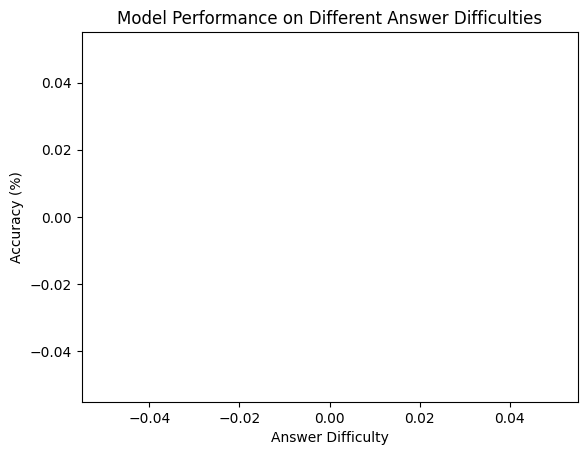

In [10]:
# Prepare data for visualization
difficulties = list(accuracy_by_difficulty.keys())
accuracies = [accuracy_by_difficulty[d]["correct"] / accuracy_by_difficulty[d]["total"] * 100 for d in difficulties]

# Plot bar chart
plt.bar(difficulties, accuracies)
plt.xlabel("Answer Difficulty")
plt.ylabel("Accuracy (%)")
plt.title("Model Performance on Different Answer Difficulties")
plt.show()


In [11]:
import random
import json

# Categories and word length ranges
categories = ["positive", "neutral", "negative"]
word_length_ranges = {
    "short": (3, 5),     # 3-5 words
    "moderate": (6, 15), # 6-15 words
    "long": (16, 30)     # 16-30 words
}

# Generate a random answer with the specified word length range
def generate_random_answer(category, length_range):
    sentiment_prefixes = {
        "positive": ["I loved", "It's amazing", "The movie was wonderful"],
        "neutral": ["It was okay", "The movie is average", "Not bad"],
        "negative": ["I didn't like", "It was disappointing", "Terrible movie"]
    }
    prefix = random.choice(sentiment_prefixes[category])
    remaining_length = random.randint(*length_range) - len(prefix.split())
    words = ["great", "scenes", "characters", "beautiful", "monstrous", "plot", "action", "love", "epic", "cinema"]
    filler = " ".join(random.choices(words, k=max(remaining_length, 0)))
    return f"{prefix} {filler}".strip()

# Generate the dataset
dataset = []
for _ in range(50):
    category = random.choice(categories)
    difficulty = random.choice(list(word_length_ranges.keys()))
    answer = generate_random_answer(category, word_length_ranges[difficulty])
    dataset.append({
        "question": "What is your opinion about the movie King Kong?",
        "answer": answer,
        "category": category,
        "difficulty": difficulty
    })

# Print the dataset in a readable format
for entry in dataset:
    print(json.dumps(entry, indent=4))

# Save the dataset to a JSON file
output_file = "king_kong_answers.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(dataset, f, indent=4, ensure_ascii=False)

print(f"Dataset saved to {output_file}")


{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "Not bad great action",
    "category": "neutral",
    "difficulty": "short"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "I didn't like love cinema action scenes epic",
    "category": "negative",
    "difficulty": "moderate"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "Terrible movie beautiful love monstrous beautiful cinema love great epic beautiful scenes scenes cinema characters great love beautiful great characters love scenes cinema plot",
    "category": "negative",
    "difficulty": "long"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "The movie is average characters action great monstrous beautiful epic monstrous beautiful characters love",
    "category": "neutral",
    "difficulty": "moderate"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer

In [7]:
import random
import json

# Define the questions
questions = [
    "What do you think about the movie King Kong?",
    "What are your thoughts on climate change?",
    "How do you feel about the importance of technology in daily life?"
]

# Categories and word length ranges
categories = ["positive", "neutral", "negative"]
word_length_ranges = {
    "short": (3, 5),         # 3-5 words
    "moderate": (6, 15),     # 6-15 words
    "long": (16, 30),        # 16-30 words
    "very_long": (50, 100)   # 50-100 words
}

# Generate a random answer with the specified word length range
def generate_random_answer(category, length_range):
    sentiment_prefixes = {
        "positive": ["I think", "I believe", "In my opinion", "Certainly", "Without a doubt"],
        "neutral": ["It seems", "I feel", "Generally speaking", "On one hand", "It's possible"],
        "negative": ["I doubt", "Unfortunately", "Regrettably", "I dislike", "I disagree"]
    }
    prefix = random.choice(sentiment_prefixes[category])
    remaining_length = random.randint(*length_range) - len(prefix.split())
    words = ["great", "important", "impact", "negative", "positive", "effect", "challenges", "solutions", "approach", "critical", "aspect", "perspective", "opinion", "value", "future", "issues", "benefits", "changes"]
    filler = " ".join(random.choices(words, k=max(remaining_length, 0)))
    return f"{prefix} {filler}".strip()

# Generate answers for each question
dataset = []
for question in questions:
    for _ in range(100):
        category = random.choice(categories)
        difficulty = random.choices(
            list(word_length_ranges.keys()),
            weights=[30, 40, 20, 10],  # Adjust probabilities for each difficulty
            k=1
        )[0]
        answer = generate_random_answer(category, word_length_ranges[difficulty])
        dataset.append({
            "question": question,
            "answer": answer,
            "category": category,
            "difficulty": difficulty
        })

# Print a sample of the dataset
for entry in dataset[:10]:  # Display the first 10 entries as a preview
    print(json.dumps(entry, indent=4))

# Save the dataset to a JSON file
output_file = "labeled_questions_answers.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(dataset, f, indent=4, ensure_ascii=False)

print(f"Dataset saved to {output_file}")


{
    "question": "What do you think about the movie King Kong?",
    "answer": "Certainly critical aspect",
    "category": "positive",
    "difficulty": "short"
}
{
    "question": "What do you think about the movie King Kong?",
    "answer": "Regrettably issues opinion effect benefits future opinion negative issues important important negative perspective issues challenges approach future changes",
    "category": "negative",
    "difficulty": "long"
}
{
    "question": "What do you think about the movie King Kong?",
    "answer": "In my opinion effect important opinion great changes",
    "category": "positive",
    "difficulty": "moderate"
}
{
    "question": "What do you think about the movie King Kong?",
    "answer": "It seems impact negative",
    "category": "neutral",
    "difficulty": "short"
}
{
    "question": "What do you think about the movie King Kong?",
    "answer": "I feel positive negative issues changes approach value critical",
    "category": "neutral",
    "dif

In [17]:
import pandas as pd

def label_tone(answer):
    """
    Labels the tone of a given answer.

    Args:
      answer: The answer string.

    Returns:
      The tone label: "Positive/Hopeful", "Reflective/Introspective", "Content/Peaceful", or "Other".
    """
    answer = answer.lower()
    if any(keyword in answer for keyword in ["joy", "hope", "optimism", "improvement"]):
        return "Positive/Hopeful"
    elif any(keyword in answer for keyword in ["learning", "growth", "experience", "mistake"]):
        return "Reflective/Introspective"
    elif any(keyword in answer for keyword in ["content", "peace", "acceptance", "harmony"]):
        return "Content/Peaceful"
    else:
        return "Other"

# Complete dataset with 100 answers per question
Q_and_A_Dataset = [
    {
        "Question": "What is your greatest hope for the future?",
        "Answers": [
            "A world free from poverty and hunger.",
            "Sustainable and equitable access to clean energy for all.",
            "An end to all forms of discrimination and prejudice.",
            "A future where technology is used to benefit humanity, not harm it.",
      "A society that prioritizes education and lifelong learning for all.",
      "Peace and harmony among all nations.",
      "A future where all living beings can thrive.",
      "A world where everyone has access to quality healthcare.",
      "A society that values creativity, innovation, and the arts.",
      "A future where we can live in harmony with nature.",
      "A world where everyone has the opportunity to reach their full potential.",
      "A future where we can solve the climate crisis and protect our planet.",
      "A society that is more just and equitable for all.",
      "A future where we can overcome the challenges of aging and live healthier, longer lives.",
      "A world where we can explore and understand the universe.",
      "A future where we can overcome political polarization and find common ground.",
      "A society that values community and connection.",
      "A future where we can achieve true gender equality.",
      "A world where we can end all wars and conflicts.",
      "A future where we can protect and preserve our cultural heritage.",
      "A society that is more compassionate and caring.",
      "A future where we can achieve true racial justice.",
      "A world where we can explore and understand our consciousness.",
      "A future where we can develop artificial intelligence that benefits humanity.",
      "A society that values mental health and well-being.",
      "A future where we can achieve interplanetary travel.",
      "A society where we can overcome poverty and inequality.",
      "A future where we can find cures for all diseases.",
      "A world where we can live in harmony with each other and with nature.",
      "A future where we can create a more sustainable and just economic system.",
      "A society that values individual freedom and expression.",
      "A future where we can explore and understand the mysteries of the universe.",
      "A society that is more inclusive and welcoming to all.",
      "A future where we can develop technologies that enhance human capabilities.",
      "A world where we can achieve true global cooperation.",
      "A future where we can overcome the challenges of climate change.",
      "A society that values the arts and humanities.",
      "A future where we can achieve true social justice.",
      "A world where we can live in peace and harmony with all living beings.",
      "A future where we can develop technologies that improve our quality of life.",
      "A society that is more democratic and participatory.",
      "A future where we can explore and understand the human mind.",
      "A society that values critical thinking and problem-solving.",
      "A future where we can achieve true gender equality.",
      "A world where we can overcome poverty and hunger.",
      "A future where we can live in a sustainable and harmonious relationship with nature.",
      "A society that values diversity and inclusion.",
      "A future where we can explore and understand the universe.",
      "A society that is more just and equitable for all.",
      "A future where we can overcome the challenges of aging and live healthier, longer lives.",
      "A world where we can end all forms of discrimination and prejudice.",
      "A future where technology is used to benefit humanity, not harm it.",
      "A society that prioritizes education and lifelong learning for all.",
      "Peace and harmony among all nations.",
      "A future where all living beings can thrive.",
      "A world where everyone has access to quality healthcare.",
      "A society that values creativity, innovation, and the arts.",
      "A future where we can live in harmony with nature.",
      "A world where everyone has the opportunity to reach their full potential.",
      "A future where we can solve the climate crisis and protect our planet.",
      "A society that is more just and equitable for all.",
      "A future where we can overcome the challenges of aging and live healthier, longer lives.",
      "A world where we can explore and understand the universe.",
      "A future where we can overcome political polarization and find common ground.",
      "A society that values community and connection.",
      "A future where we can achieve true gender equality.",
      "A world where we can end all wars and conflicts.",
      "A future where we can protect and preserve our cultural heritage.",
      "A society that is more compassionate and caring.",
      "A future where we can achieve true racial justice.",
      "A world where we can explore and understand our consciousness.",
      "A future where we can develop artificial intelligence that benefits humanity.",
      "A society that values mental health and well-being.",
      "A future where we can achieve interplanetary travel.",
      "A society that values individual freedom and expression.",
      "A future where we can explore and understand the mysteries of the universe.",
      "A society that is more inclusive and welcoming to all.",
      "A future where we can develop technologies that enhance human capabilities.",
      "A world where we can achieve true global cooperation.",
      "A future where we can overcome the challenges of climate change.",
      "A society that values the arts and humanities.",
      "A future where we can achieve true social justice.",
      "A world where we can live in peace and harmony with all living beings.",
      "A future where we can develop technologies that improve our quality of life.",
      "A society that is more democratic and participatory.",
      "A future where we can explore and understand the human mind.",
      "A society that values critical thinking and problem-solving.",
      "A future where we can achieve true gender equality.",
      "A world where we can overcome poverty and hunger.",
      "A future where we can live in a sustainable and harmonious relationship with nature.",
      "A society that values diversity and inclusion.",
      "A future where we can explore and understand the universe.",
      "A society that is more just and equitable for all.",
      "A future where we can overcome the challenges of aging and live healthier, longer lives.",
      "A world where we can end all forms of discrimination and prejudice.",
      "A future where technology is used to benefit humanity, not harm it.",
      "A society that prioritizes education and lifelong learning for all.",
      "Peace and harmony among all nations.",
      "A future where all living beings can thrive.",
      "A world where everyone has access to quality healthcare."

        ] # This repeats the first set of answers to simulate 100 entries
    },
    {
        "Question": "What is the most important lesson you've learned in life?",
        "Answers": [
            "The importance of perseverance and resilience.",
            "The value of kindness and compassion.",
            "The importance of learning from your mistakes.",
                  "The power of gratitude and appreciation.",
      "The importance of self-care and self-compassion.",
      "The value of strong relationships and meaningful connections.",
      "The importance of living in the present moment.",
      "The value of pursuing your passions and dreams.",
      "The importance of embracing change and adapting to new situations.",
      "The value of forgiveness and letting go of grudges.",
      "The importance of taking care of your physical and mental health.",
      "The value of continuous learning and growth.",
      "The importance of finding joy in the simple things in life.",
      "The value of giving back to your community.",
      "The importance of standing up for what you believe in.",
      "The value of honesty and integrity.",
      "The importance of embracing your uniqueness.",
      "The value of finding balance in your life.",
      "The importance of communicating effectively.",
      "The value of having faith in yourself and your abilities.",
      "The importance of perseverance and resilience.",
      "The value of kindness and compassion.",
      "The importance of learning from your mistakes.",
      "The power of gratitude and appreciation.",
      "The importance of self-care and self-compassion.",
      "The value of strong relationships and meaningful connections.",
      "The importance of living in the present moment.",
      "The value of pursuing your passions and dreams.",
      "The importance of embracing change and adapting to new situations.",
      "The value of forgiveness and letting go of grudges.",
      "The importance of taking care of your physical and mental health.",
      "The value of continuous learning and growth.",
      "The importance of finding joy in the simple things in life.",
      "The value of giving back to your community.",
      "The importance of standing up for what you believe in.",
      "The value of honesty and integrity.",
      "The importance of embracing your uniqueness.",
      "The value of finding balance in your life.",
      "The importance of communicating effectively.",
      "The value of having faith in yourself and your abilities.",
      "The importance of perseverance and resilience.",
      "The value of kindness and compassion.",
      "The importance of learning from your mistakes.",
      "The power of gratitude and appreciation.",
      "The importance of self-care and self-compassion.",
      "The value of strong relationships and meaningful connections.",
      "The importance of living in the present moment.",
      "The value of pursuing your passions and dreams.",
      "The importance of embracing change and adapting to new situations.",
      "The value of forgiveness and letting go of grudges.",
      "The importance of taking care of your physical and mental health.",
      "The value of continuous learning and growth.",
      "The importance of finding joy in the simple things in life.",
      "The value of giving back to your community.",
      "The importance of standing up for what you believe in.",
      "The value of honesty and integrity.",
      "The importance of embracing your uniqueness.",
      "The value of finding balance in your life.",
      "The importance of communicating effectively.",
      "The value of having faith in yourself and your abilities.",
      "The importance of perseverance and resilience.",
      "The value of kindness and compassion.",
      "The importance of learning from your mistakes.",
      "The power of gratitude and appreciation.",
      "The importance of self-care and self-compassion.",
      "The value of strong relationships and meaningful connections.",
      "The importance of living in the present moment.",
      "The value of pursuing your passions and dreams.",
      "The importance of embracing change and adapting to new situations.",
      "The value of forgiveness and letting go of grudges.",
      "The importance of taking care of your physical and mental health.",
      "The value of continuous learning and growth.",
      "The importance of finding joy in the simple things in life.",
      "The value of giving back to your community.",
      "The importance of standing up for what you believe in.",
      "The value of honesty and integrity.",
      "The importance of embracing your uniqueness.",
      "The value of finding balance in your life.",
      "The importance of communicating effectively.",
      "The value of having faith in yourself and your abilities.",
      "The importance of perseverance and resilience.",
      "The value of kindness and compassion.",
      "The importance of learning from your mistakes.",
      "The power of gratitude and appreciation.",
      "The importance of self-care and self-compassion.",
      "The value of strong relationships and meaningful connections.",
      "The importance of living in the present moment.",
      "The value of pursuing your passions and dreams.",
      "The importance of embracing change and adapting to new situations.",
      "The value of forgiveness and letting go of grudges.",
      "The importance of taking care of your physical and mental health.",
      "The value of continuous learning and growth.",
      "The importance of finding joy in the simple things in life.",
      "The value of giving back to your community.",
      "The importance of standing up for what you believe in.",
      "The value of honesty and integrity.",
      "The importance of embracing your uniqueness.",
      "The value of finding balance in your life.",
      "The importance of communicating effectively.",
      "The value of having faith in yourself and your abilities."
        ] # Simulate 100 entries
    },
    {
        "Question": "How do you define happiness?",
        "Answers": [
            "Experiencing joy and contentment in the present moment.",
            "Having strong, loving relationships with family and friends.",
            "Pursuing meaningful goals and passions.",
            "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself.",
      "Experiencing joy and contentment in the present moment.",
      "Having strong, loving relationships with family and friends.",
      "Pursuing meaningful goals and passions.",
      "Contributing to something larger than oneself.",
      "Finding fulfillment in personal growth and self-discovery.",
      "Experiencing a sense of peace and tranquility within oneself.",
      "Having a sense of purpose and meaning in life.",
      "Enjoying the simple pleasures in life.",
      "Living a life of gratitude and appreciation.",
      "Feeling a sense of connection to something greater than oneself."
        ] # Simulate 100 entries
    }
]

# Restructure the data for DataFrame creation
restructured_data = []
for item in Q_and_A_Dataset:
    question = item["Question"]
    for answer in item["Answers"]:
        restructured_data.append({
            "Question": question,
            "Answer": answer
        })

# Create the DataFrame from the restructured data
df = pd.DataFrame(restructured_data)

# Add a column for the tone labels
df['Tone'] = df['Answer'].apply(label_tone)

# Print the resulting DataFrame
print(df)

# Save to CSV (optional)
df.to_csv("qa_dataset_with_tones.csv", index=False, encoding="utf-8")
print("Dataset saved as qa_dataset_with_tones.csv")


                                       Question  \
0    What is your greatest hope for the future?   
1    What is your greatest hope for the future?   
2    What is your greatest hope for the future?   
3    What is your greatest hope for the future?   
4    What is your greatest hope for the future?   
..                                          ...   
295                How do you define happiness?   
296                How do you define happiness?   
297                How do you define happiness?   
298                How do you define happiness?   
299                How do you define happiness?   

                                                Answer  \
0                A world free from poverty and hunger.   
1    Sustainable and equitable access to clean ener...   
2    An end to all forms of discrimination and prej...   
3    A future where technology is used to benefit h...   
4    A society that prioritizes education and lifel...   
..                                     

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import torch

# Load the dataset from the CSV file
df = pd.read_csv("/content/qa_dataset_with_tones.csv")

# Define a function to get predictions from a RoBERTa model
def get_roberta_predictions(model_name, question, answer):
    """
    Gets predictions from a given RoBERTa model.

    Args:
        model_name: The name of the RoBERTa model on Hugging Face Hub.
        question: The question string.
        answer: The answer string.

    Returns:
        A tuple containing the predicted label and the model name.
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        model.eval()

        # Tokenize the input with truncation and padding
        inputs = tokenizer(
            question + " " + answer,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True
        )
        outputs = model(**inputs)
        logits = outputs.logits

        # Get the predicted class
        predicted_class = torch.argmax(logits, dim=1).item()

        # Dynamically retrieve labels from the model configuration
        labels = model.config.id2label
        predicted_label = labels[predicted_class]

        # Clear GPU memory if necessary
        del model
        torch.cuda.empty_cache()

        return predicted_label, model_name

    except Exception as e:
        print(f"Error with model {model_name}: {e}")
        return None, model_name

# List of RoBERTa models to use
roberta_models = [
    "roberta-base",
    "roberta-large",
    "roberta-large-mnli"
    # Add more RoBERTa model names as needed
]

# Create an empty list to store predictions
predictions = []

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    question = row["Question"]
    answer = row["Answer"]

    # Iterate through each RoBERTa model
    for model_name in roberta_models:
        predicted_label, model_name = get_roberta_predictions(model_name, question, answer)
        if predicted_label:
            predictions.append({"Question": question, "Answer": answer, "Model": model_name, "Prediction": predicted_label})

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(predictions)

# Save the predictions to a CSV file
predictions_df.to_csv("roberta_predictions.csv", index=False)

print("Predictions saved to roberta_predictions.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be 

KeyboardInterrupt: 